In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## SIR

In [2]:
def model(init, params, T, dt):
    beta, gamma = params
    S0, I0, R0 = init
    N = S0 + I0 + R0
    
    S, I, R = [S0], [I0], [R0]
    for t in range(1, int(T / dt)):
        S_to_I = min(S[-1], (beta * S[-1] * I[-1] / N) * dt)
        I_to_R = min(I[-1], (gamma * I[-1]) * dt)
        
        next_S = S[-1] - S_to_I
        next_I = I[-1] + S_to_I - I_to_R
        next_R = R[-1] + I_to_R
        
        S.append(next_S)
        I.append(next_I)
        R.append(next_R)
        
    return np.stack([S, I, R])

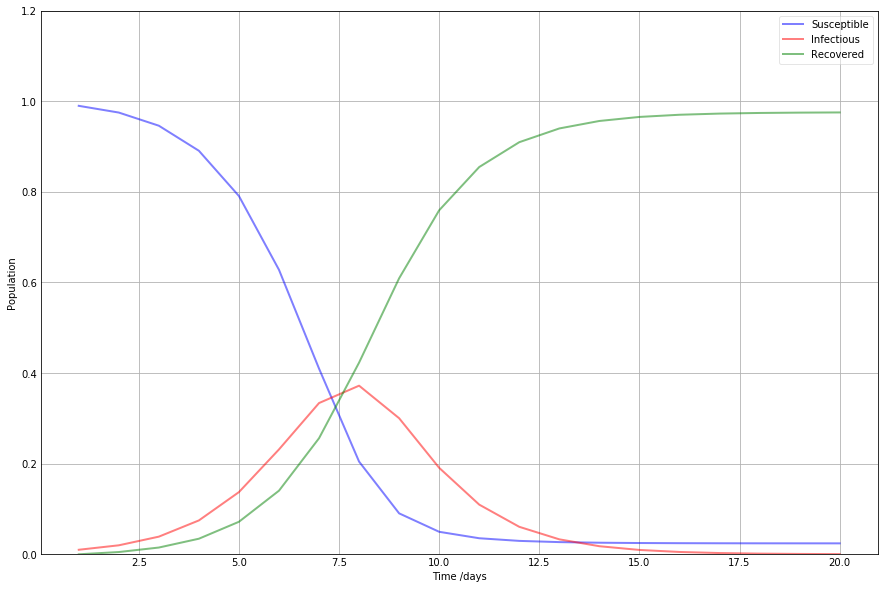

In [3]:
N = 100
beta = 1.5
gamma = 0.5

init = [N-1, 1, 0]
params = beta, gamma
T = 20
dt = 1.

results = model(init, params, T, dt)
S = results[0]
I = results[1]
R = results[2]
cases = (S[1:] - S[0:-1]) / 10.

t = np.linspace(1, T, int(T/dt))
fig = plt.figure(facecolor='w', figsize=(15, 10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infectious')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time /days')
ax.set_ylabel('Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid()
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

## ABC

ABC = Approximate Bayesian Computation

ABC is a class of algorithms that can be used to estimate the posterior distributions of model parameters without computing the likelihood. Therefore, it is useful for complex models where the likelihood is intractable or computationally costly to evaluate, typically in biological sciences (genetics, epidemiology, etc.).

The most basic form of ABC is the ABC rejection algorithm. Let's say we want to infer the true parameter that generated the observed data. We suppose a prior distribution of this parameter, sample $n$ particles from this distribution and generate synthetic data from each of these particles. Based on summary statistics, we can calculate how close synthetic data are to the observed data. We then accept a particle if the data generated from it is sufficiently close to the observed data (given a threshold $\epsilon$). Thus, we approximate the posterior distribution based on the accepted particles.

In this setting, there is a huge tradeoff between the precision and the computation time, both depending on the threshold and the search space (prior). We solve this problem with ABC-SMC.

In [4]:
def ABC_algorithm(generate_theta, run_model, calc_distance, D, n_particles, n_params, eps):
    results = np.zeros((n_particles, n_params + 1))

    i, j = 0, 0
    while i < n_particles:

        theta_star = generate_theta()
        D_star = run_model(theta_star)
        distance = calc_distance(D, D_star)
        #print(distance)

        if distance < eps:
            results[i,:] = theta_star + [distance]
            i += 1
            
            if i % (n_particles/10) == 0:
                print(i)
    
    return results

In [5]:
def generate_theta():
    beta_star = np.random.uniform(0, 3, 1)
    gamma_star = np.random.uniform(0, 1, 1)
    theta_star = [beta_star, gamma_star]
    return theta_star

def run_model(theta):
    N = 100
    init = [N-1, 1, 0]
    T = 20
    dt = 1.
    params = theta # beta, gamma
    results = model(init, params, T, dt)
    S = results[0]
    I = results[1]
    R = results[2]
    return S, I, R

def calc_distance(D, D_star):
    S, I, R = D
    S_star, I_star, R_star = D_star
    mse = ((I - I_star) ** 2).mean()
    return mse

In [12]:
beta, gamma = 1.5, 0.5
theta = beta, gamma
D = run_model(theta)

results = ABC_algorithm(generate_theta, run_model, calc_distance, D, n_particles=1000, n_params=2, eps=20)

100
200
300
400
500
600
700
800
900
1000


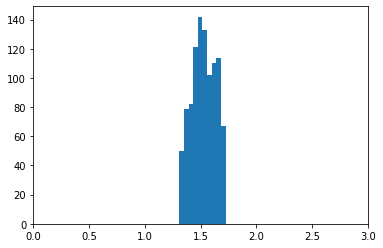

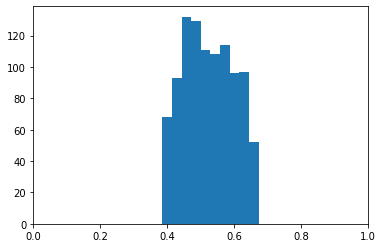

In [13]:
plt.xlim(0, 3)
plt.hist(results[:,0])
plt.show()

plt.xlim(0, 1)
plt.hist(results[:,1])
plt.show()

## ABC-SMC

ABC-SMC is an improvement of ABC with Sequential Monte Carlo. The idea is very intuitive: instead of sampling many particles from the prior distribution until with accept enough of them with a given threshold, we will proceed sequentially with less and less coarser thresholds. At each step, we'll perform an ABC rejection algorithm but instead of using the prior distribution, we will use an intermediate posterior distribution estimated from the previous time step. By using diminishing threshold at each time step, we'll refine the posterior distribution. It solves both the precision and the computation time problems because the search space is shrinking through the time as well as the threshold.

In [84]:
def perturbation_kernel(theta, s=0.01):
    #return theta
    return theta + np.random.normal(0., 0.01, size=1)

def generate_theta(results=None, weights=None):
    if results is None:
        # prior distribution
        beta_star_star = np.random.uniform(0, 3, 1)
        gamma_star_star = np.random.uniform(0, 1, 1)
        theta_star_star = [beta_star_star, gamma_star_star]
    else:
        # intermediate posterior
        accepted_betas = results[:, 0]
        weights_beta = weights[:, 0]
        beta_star = np.random.choice(a=accepted_betas, p=weights_beta)
        beta_star_star = perturbation_kernel(beta_star)
        
        accepted_gammas = results[:, 1]
        weights_gamma = weights[:, 1]
        gamma_star = np.random.choice(a=accepted_gammas, p=weights_gamma)
        gamma_star_star = perturbation_kernel(gamma_star)
        
        #mu, sig = np.mean(accepted_betas), np.sqrt(np.var(accepted_betas))
        #beta_star_star = np.random.normal(mu, sig)
        #mu, sig = np.mean(accepted_gammas), np.sqrt(np.var(accepted_gammas))
        #gamma_star_star = np.random.normal(mu, sig)
        
        theta_star_star = [beta_star_star, gamma_star_star]
    return theta_star_star

def run_model(theta):
    N = 100
    init = [N-1, 1, 0]
    T = 20
    dt = 1.
    params = theta # beta, gamma
    results = model(init, params, T, dt)
    S = results[0]
    I = results[1]
    R = results[2]
    return S, I, R

def calc_distance(D, D_star):
    S, I, R = D
    S_star, I_star, R_star = D_star
    mse = ((I - I_star) ** 2).mean()
    return mse

In [85]:
epsilons = [1000, 100, 10, 1, 0.1]
n_particles = 1000
n_params = 2

results = np.zeros((len(epsilons), n_particles, n_params + 1))
weights = np.zeros((len(epsilons), n_particles, n_params))
for t in range(len(epsilons)):
    print(t)
    i = 0
    while i < n_particles:
        
        if t == 0:
            theta_star = generate_theta()
        else:
            theta_star = generate_theta(results[t-1], weights[t-1])
            
        D_star = run_model(theta_star)
        distance = calc_distance(D, D_star)

        if distance < epsilons[t]:
            results[t, i, :] = theta_star + [distance]
            weights[t, i] = [1., 1.]
            i += 1
            
    # Normalize weights
    weights[t] = weights[t] / np.sum(weights[t], axis=0).reshape((1, -1))

0
1
2
3
4


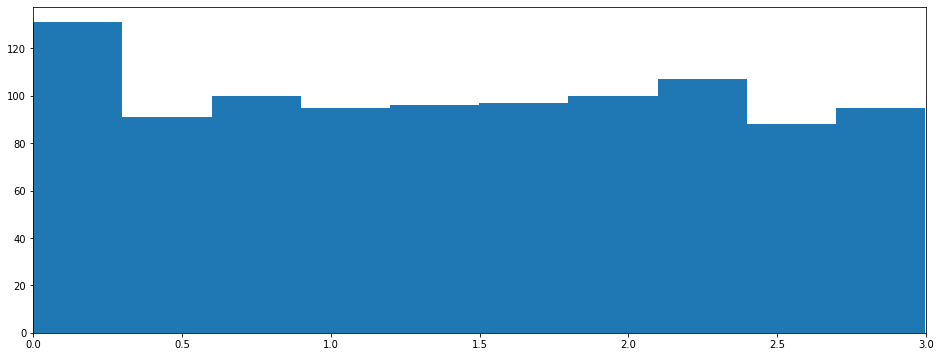

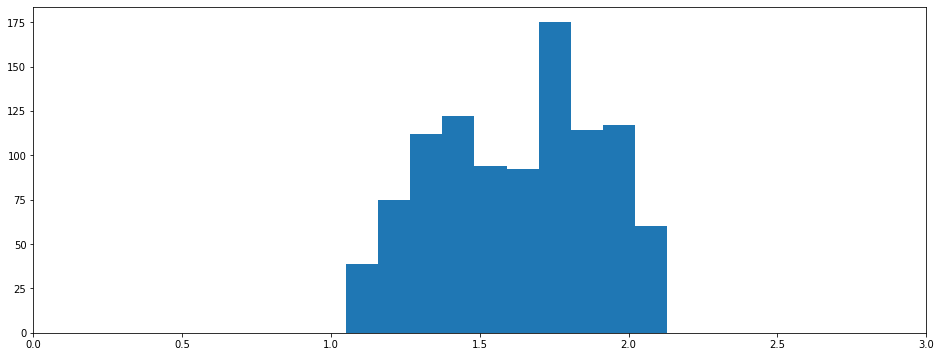

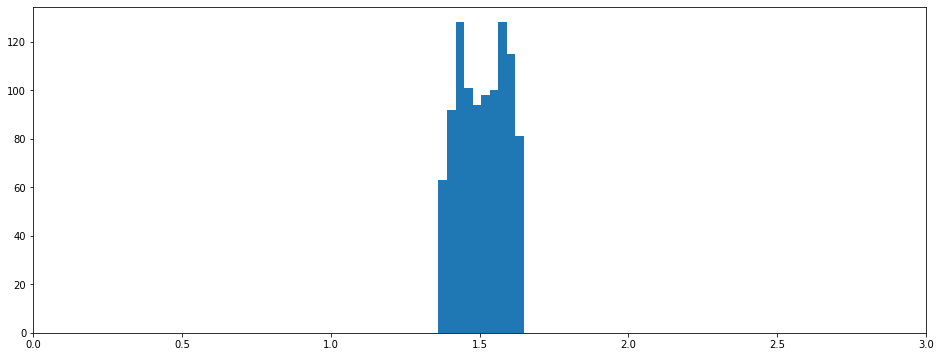

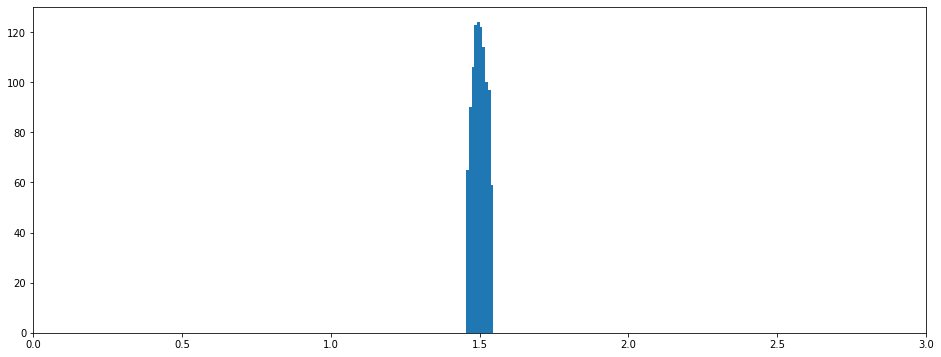

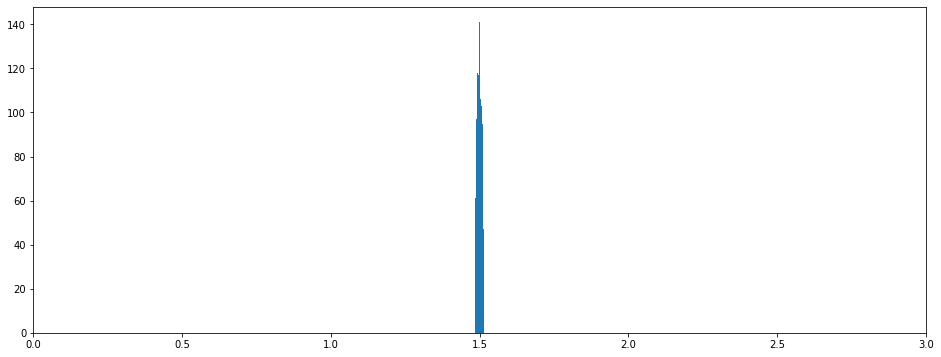

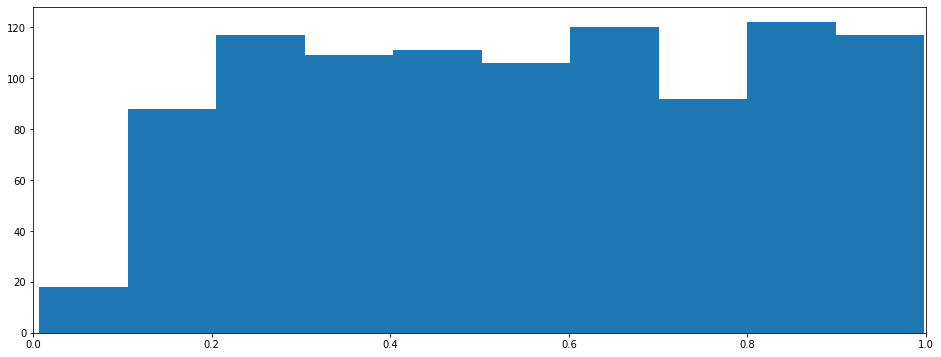

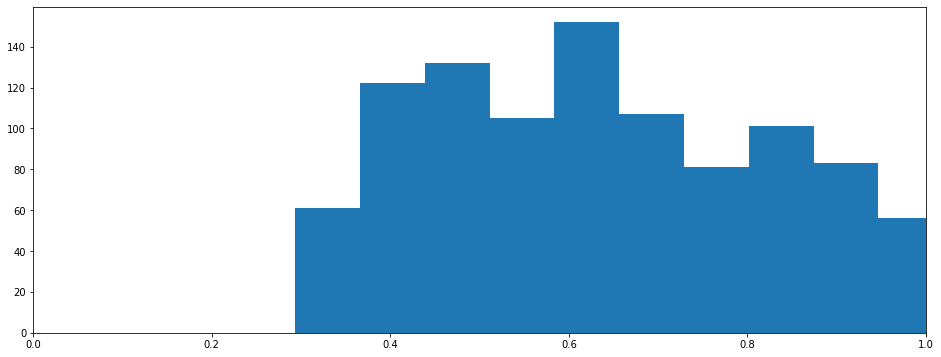

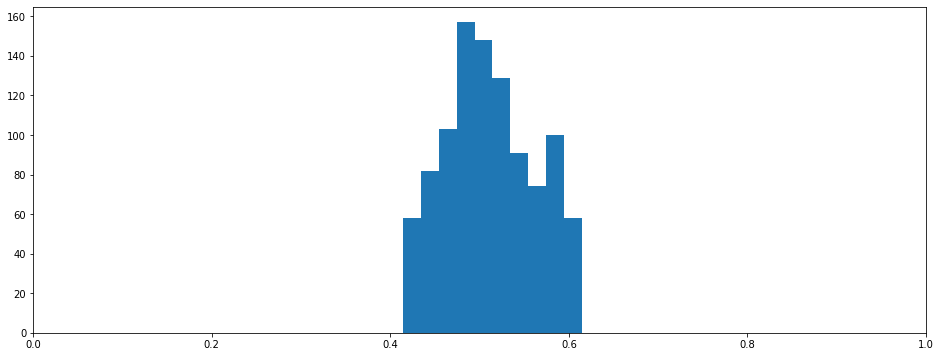

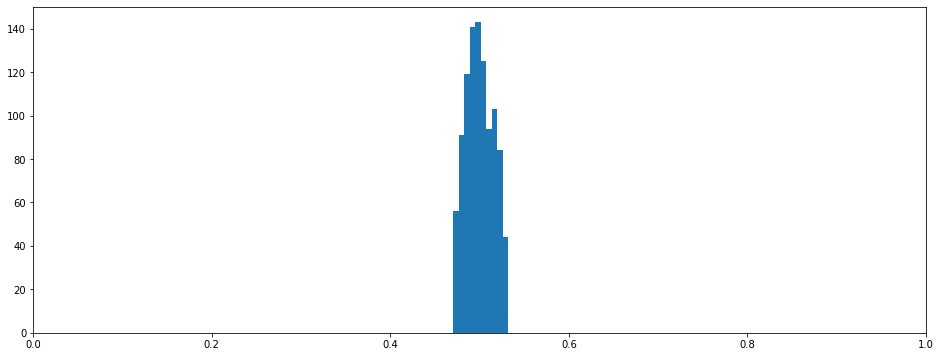

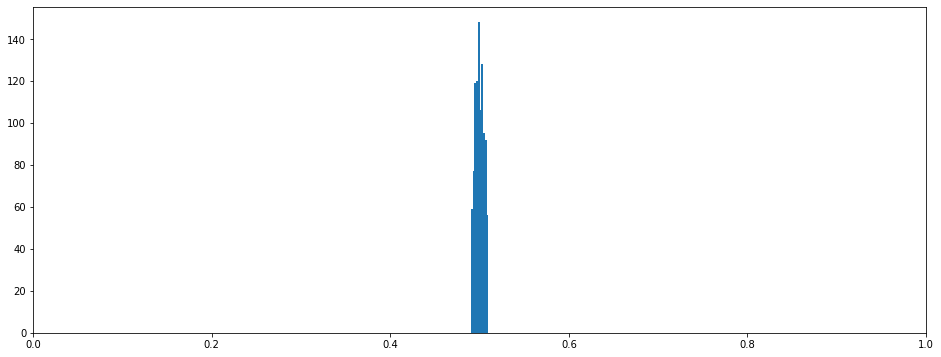

In [86]:
for t in range(len(epsilons)):
    plt.figure(figsize=(16, 6))
    plt.xlim(0, 3)
    plt.hist(results[t,:,0])
    plt.show()
for t in range(len(epsilons)):
    plt.figure(figsize=(16, 6))
    plt.xlim(0, 1)
    plt.hist(results[t,:,1])
    plt.show()

## Real data

In [57]:
df = pd.read_excel('./data/COVID-19-geographic-disbtribution-worldwide.xlsx')
df = df[df.countriesAndTerritories == 'France'].sort_values('dateRep')
print(df.shape)
df.head(3)

(108, 10)


,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
3770,2019-12-31,31,12,2019,0,0,France,FR,FRA,66987244.0
3769,2020-01-01,1,1,2020,0,0,France,FR,FRA,66987244.0
3768,2020-01-02,2,1,2020,0,0,France,FR,FRA,66987244.0


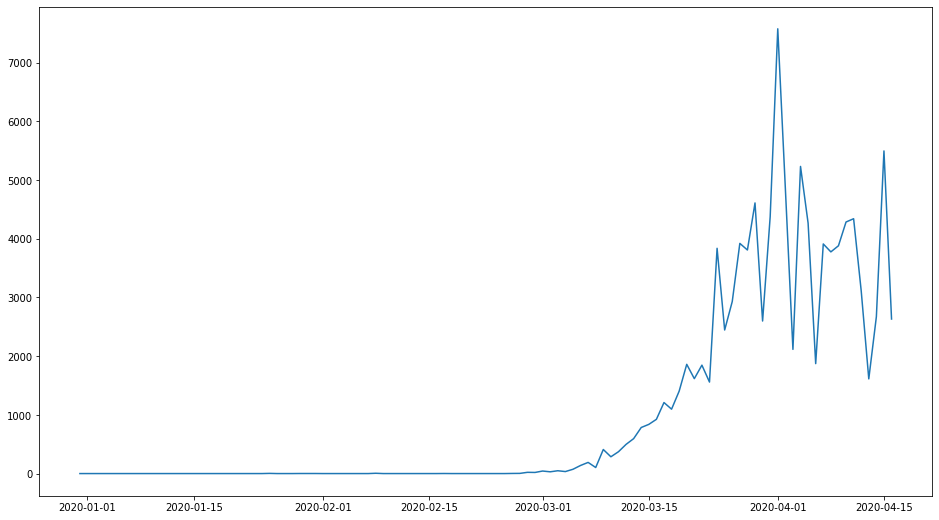

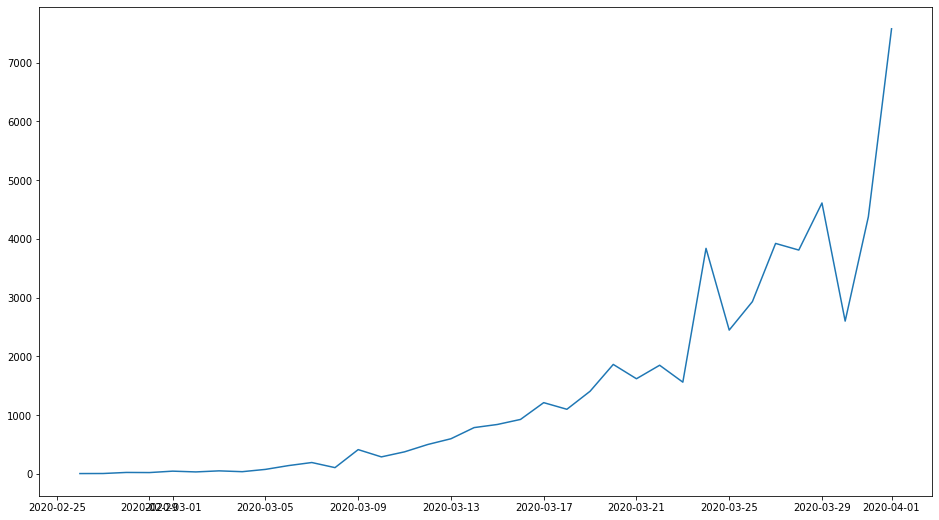

36
2


In [9]:
plt.figure(figsize=(16,9))
plt.plot(df['dateRep'], df['cases'])
plt.show()

plt.figure(figsize=(16,9))
tmp = df[(df['dateRep'] >= '2020-02-26') & (df['dateRep'] <= '2020-04-01')]
plt.plot(tmp['dateRep'], tmp['cases'])
plt.show()

#plt.figure(figsize=(16,9))
#tmp = df[(df['dateRep'] > '2020-04-01')]
#plt.plot(tmp['dateRep'], tmp['cases'])
#plt.show()

print(len(tmp))
print(tmp.cases.values[0])

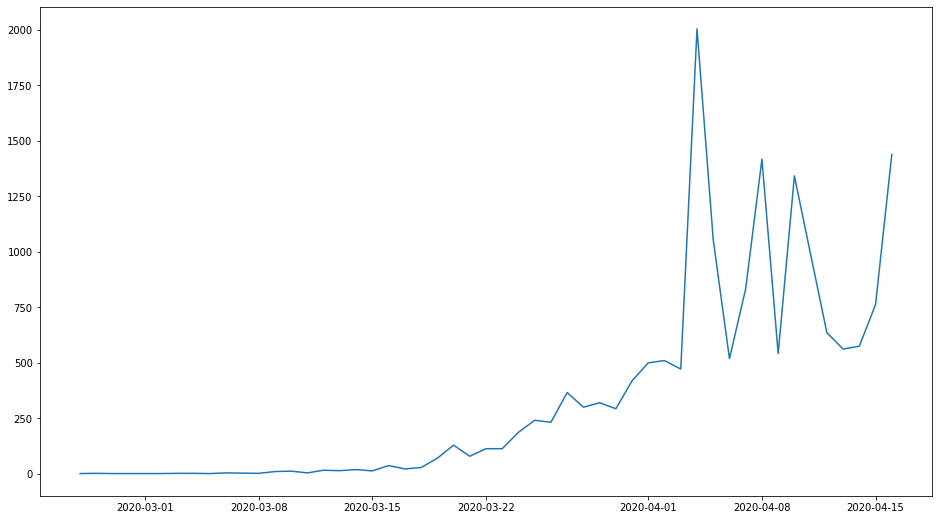

(0, 51)

In [321]:
plt.figure(figsize=(16,9))
tmp = df[(df['dateRep'] >= '2020-02-26') & (df['dateRep'] <= '2020-04-01')]
plt.plot(tmp['dateRep'], tmp['deaths'])
plt.show()

tmp.deaths.values[0], len(tmp)

In [88]:
def model(init, params, T, dt):
    beta, gamma, mu = params
    S0, I0, R0, D0 = init
    N = S0 + I0 + R0 + D0
    
    S, I, R = [S0], [I0], [R0]
    D = [D0]
    incidence = [0.]
    for t in range(1, int(T / dt)):
        S_to_I = (beta * S[-1] * I[-1] / N) * dt
        I_to_R = (gamma * I[-1]) * dt
        I_to_D = (mu * I[-1]) * dt
        
        next_S = S[-1] - min(S[-1], S_to_I)
        next_I = I[-1] + S_to_I - min(I[-1], I_to_R + I_to_D)
        next_R = R[-1] + I_to_R
        next_D = D[-1] + I_to_D
        
        S.append(next_S)
        I.append(next_I)
        R.append(next_R)
        D.append(next_D)
        
        incidence.append(S_to_I)
        
    return np.stack([S, I, R, D]), incidence

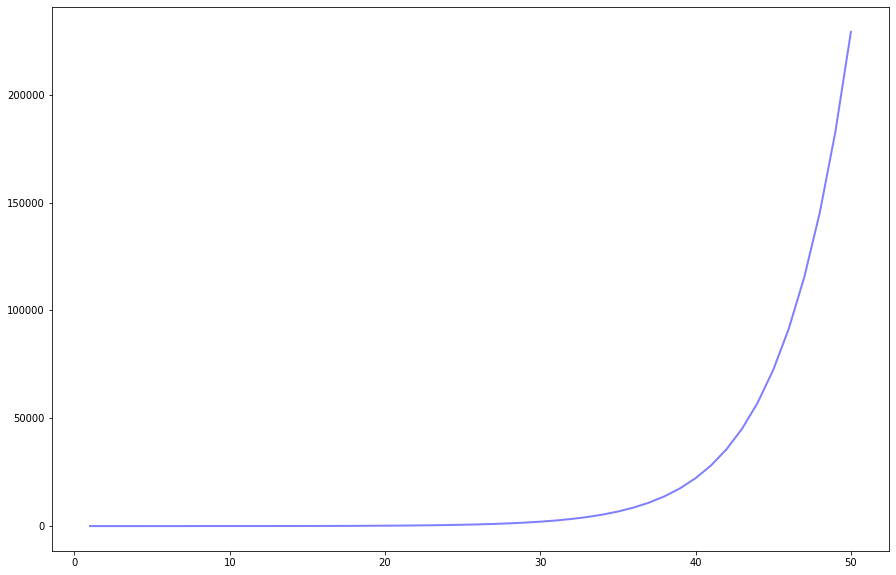

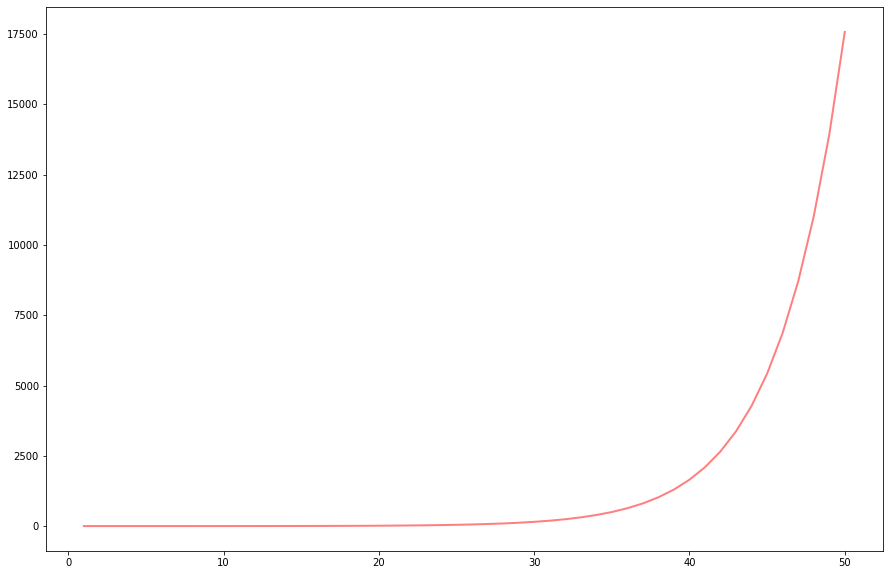

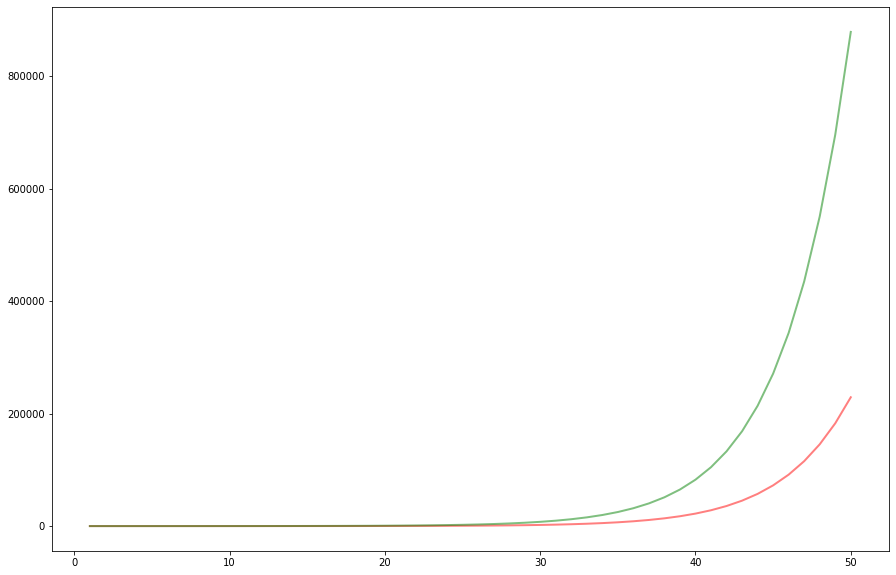

In [326]:
N = 67e6
beta = 1.270 # taux d'infection
gamma = 1. # periode d'infection
mu = 0.02 # taux de mortalité

I0 = 2
init = [N-I0, I0, 0, 0]
params = beta, gamma, mu
T = 50
dt = 1.

results, incidence = model(init, params, T, dt)
deaths = results[3]

t = np.linspace(1, T, int(T/dt))

plt.figure(figsize=(15, 10))
plt.plot(t, incidence, 'b', alpha=0.5, lw=2, label='Cases')
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(t, deaths, 'r', alpha=0.5, lw=2, label='Cases')
plt.show()

S = results[0]
I = results[1]
R = results[2]

t = np.linspace(1, T, int(T/dt))
plt.figure(figsize=(15, 10))
#plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectious')
plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time /days')
ax.set_ylabel('Population')
plt.show()

In [160]:
def ABC_algorithm(generate_theta, run_model, calc_distance, D, n_particles, n_params, eps):
    results = np.zeros((n_particles, n_params + 1))

    i, j = 0, 0
    dist = 0
    while i < n_particles:

        theta_star = generate_theta()
        D_star = run_model(theta_star)
        distance = calc_distance(D, D_star)

        if distance < eps:
            results[i,:] = theta_star + [distance]
            i += 1
            dist += distance / 1e9
            
            if i % (n_particles/10) == 0:
                print(i)
        j += 1
    print('distance moyenne:', dist*1e9 / i)
    
    return results

In [274]:
def generate_theta():
    beta_star = np.random.uniform(beta_min, beta_max, 1)
    gamma_star = np.random.uniform(gamma_min, gamma_max, 1)
    mu_star = np.random.uniform(mu_min, mu_max, 1)
    theta_star = [beta_star, gamma_star, mu_star]
    return theta_star

def run_model(theta):
    N = 67e6
    I0 = 2
    init = [N-2, 2, 0, 0]
    T = 36
    dt = 1.
    params = theta
    results, incidence = model(init, params, T, dt)
    deaths = results[3]
    return incidence, deaths

def calc_distance(D, D_star):
    incidence, deaths = D
    incidence_star, deaths_star = D_star
    
    mse1 = ((incidence - incidence_star) ** 2).mean() / (np.max(incidence_star) - np.min(incidence_star))
    mse2 = ((deaths - deaths_star) ** 2).mean() / (np.max(deaths_star) - np.min(deaths_star))
    mse = 0.5 * (mse1 + mse2)
    #print(mse1, mse2)
    return mse

In [275]:
D = tmp.cases.values, tmp.deaths.values

In [316]:
beta_min, beta_max = 1.269, 1.270
gamma_min, gamma_max = 1., 10.
mu_min, mu_max = 0.019, 0.022

results = ABC_algorithm(generate_theta, run_model, calc_distance, D, n_particles=1000, n_params=3, eps=56.35)

100
200
300
400
500
600
700
800
900
1000
distance moyenne: [56.33314157]


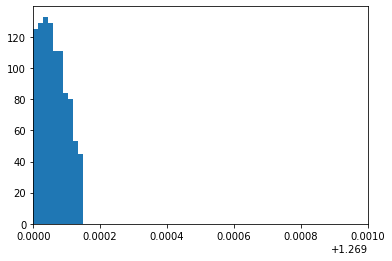

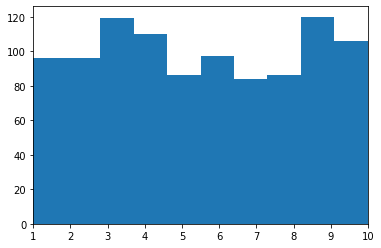

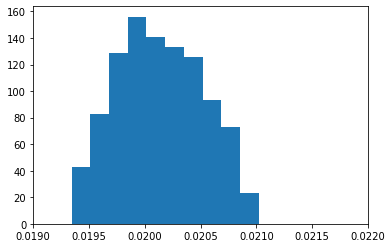

In [317]:
plt.xlim(beta_min, beta_max)
plt.hist(results[:,0])
plt.show()

plt.xlim(gamma_min, gamma_max)
plt.hist(results[:,1])
plt.show()

plt.xlim(mu_min, mu_max)
plt.hist(results[:,2])
plt.show()